In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

<h2>Creating Testing Datasets</h2>

In [2]:
def structuredF0(x):
    return ((x - 2 ** (x / 8)) * (10 * np.sin(x) + np.sin(10 * x) + np.sin(314.75 * x)))

def structuredF1(x):
    return (np.sqrt(x) - (1/10) * x) * (10 * np.sin(x) + np.sin(10 * x) + np.sin(314.2 * x))

def structuredF2(x):
    return 0.01 * ((2 ** (0.0055 * x)) * (10 * x - x ** (1.3)) * (1 / (1 + 0.0001 * x ** 2)) * (10 * np.sin(x / 10))) 

def structuredF3(x):
    return (((100 * 2 * np.pi) ** 0.5) * np.exp(-0.5 * ((x - 100) / 10) ** 2))

In [3]:
x0 = np.linspace(0, 50, 1000000)
x1 = np.linspace(0, 1000, 1000000)
x3 = np.linspace(60, 140, 10000000)

In [4]:
yStructured0 = structuredF0(x0)

yStructured1 = structuredF1(x0)

yStructured2 = structuredF2(x1)

yStructured3 = structuredF3(x3)

np.random.seed(100)
yUnstructured0 = np.zeros((1000000))
for i in range(1, len(yUnstructured0)):
    yUnstructured0[i] += yUnstructured0[i-1] + np.random.uniform(-10, high=10)
    
np.random.seed(105)
yUnstructured1 = np.zeros((1000000))
for i in range(1, len(yUnstructured1)):
    yUnstructured1[i] += yUnstructured1[i-1] + np.random.uniform(-10, high=10)
    
np.random.seed(102)
yUnstructured2 = np.zeros((1000000))
for i in range(1, len(yUnstructured2)):
    yUnstructured2[i] += yUnstructured2[i-1] + np.random.uniform(-10, high=10)

#Pure noise
np.random.seed(108)
yUnstructured3 = np.zeros((1000000))
for i in range(1, len(yUnstructured3)):
    yUnstructured3[i] = np.random.uniform(-100000, high=100000)


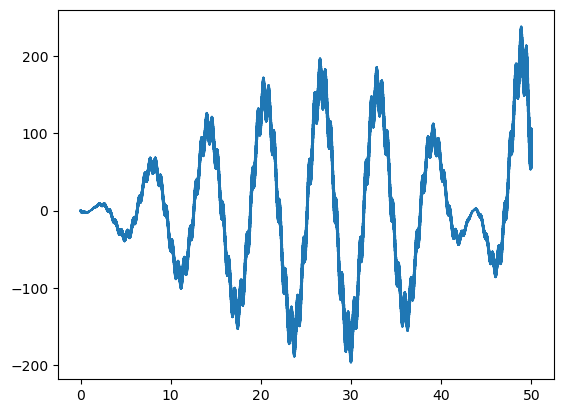

In [5]:
plt.plot(x0, yStructured0)
plt.show()

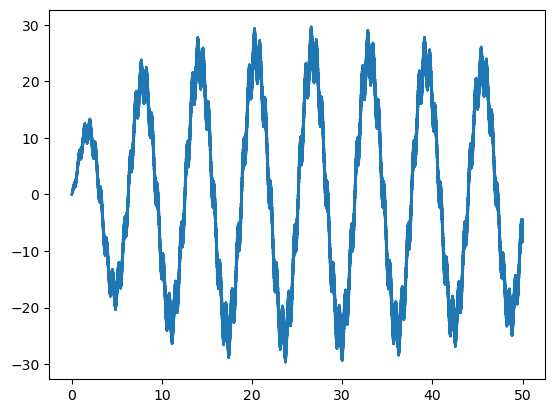

In [6]:
plt.plot(x0, yStructured1)
plt.show()

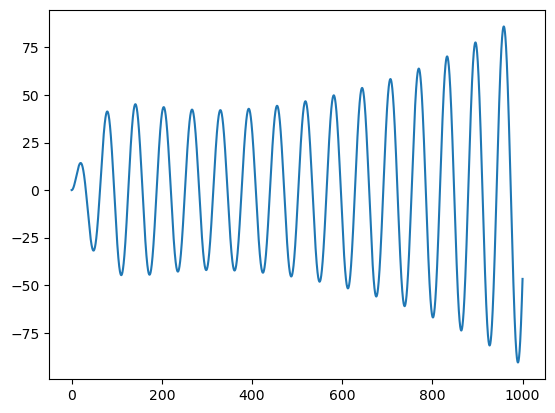

In [7]:
plt.plot(x1, yStructured2)
plt.show()

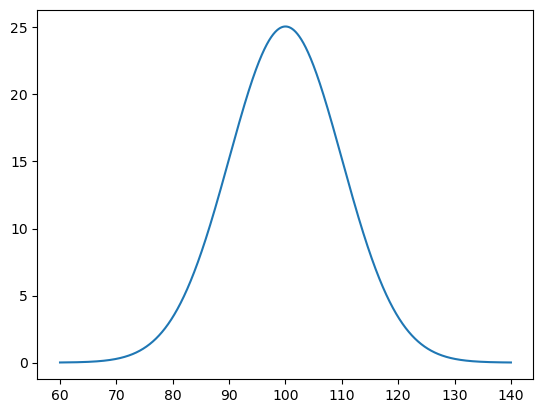

In [8]:
plt.plot(x3, yStructured3)
plt.show()

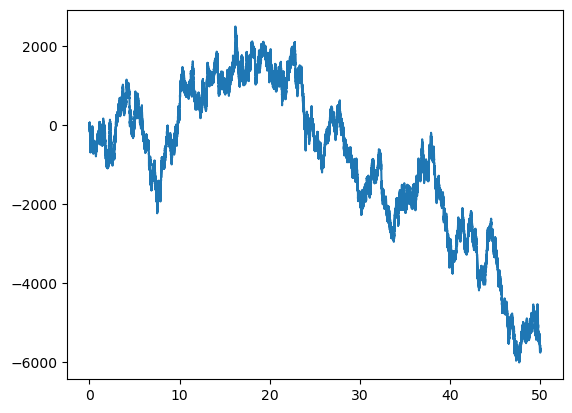

In [9]:
plt.plot(x0, yUnstructured0)
plt.show()

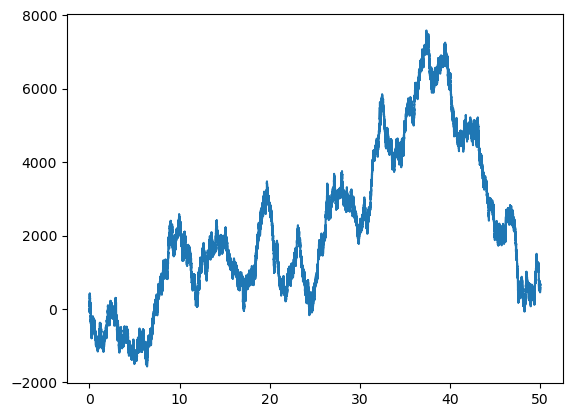

In [10]:
plt.plot(x0, yUnstructured1)
plt.show()

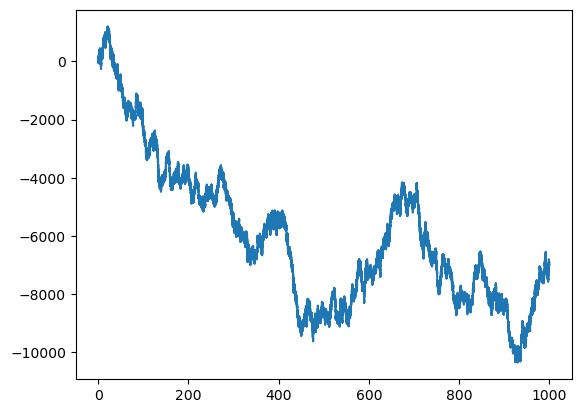

In [11]:
plt.plot(x1, yUnstructured2)
plt.show()

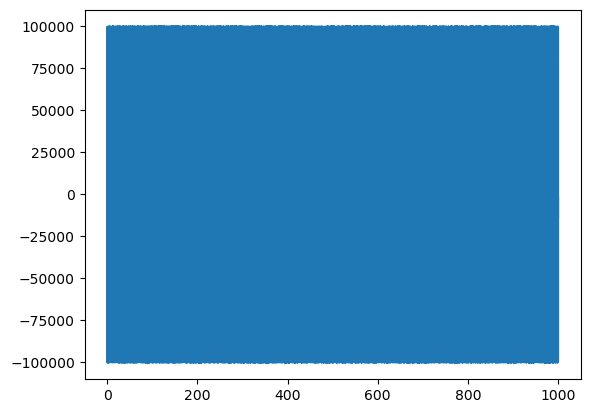

In [12]:
#Noise
plt.plot(x1, yUnstructured3)
plt.show()

<h4><i>Some miscellaneous functions used throughout the program.</i></h4>

In [13]:
#Checking if there are any points that are adjacent to equally fit points.
def smoothChecker(nump):
    count = 0
    
    for i in range(1, len(nump) - 1):
        if (nump[i] == nump[i+1]):
            count += 1
                
    return count
    

#This isn't quicker than numpy's.  No point.  
def maxCounter(nump):
    count = 0
    
    for i in range(1, len(nump) - 1):
        if (nump[i-1] < nump[i] and nump[i+1] < nump[i]):
            count += 1
            continue
    
    return count


#Guassian Normal Distribution Fuction returns probability density (could be done with standard NumPy but good practice).
#Numpy is quicker too.
def gPDF(mean, sD, x):
    return ((2 * np.pi * sD ** 2) ** -0.5) * np.exp((((x - mean) / sD) ** 2) / (2 * sD ** 2))


#Only recursive, because it's assumed that it won't go up much, and it looks better.  If we're talking 1,000+ point climbs, this could be bad.
def climb(x, nump, iterations):
    if (nump[x-1] > nump[x] and nump[x-1] > nump[x+1] and iterations > 0):
        climb(x-1, nump, iterations - 1)
    elif (nump[x+1] > nump[x] and nump[x+1] > nump[x-1] and iterations > 0):
        climb(x+1, nump, iterations - 1)
    elif (nump[x+1] > nump[x] and nump[x+1] == nump[x-1] and iterations > 0):
        climb(x+(np.random.randint(0,1)*2-1), nump, iterations - 1)
        
    return x

<h2>Randomized Point Selection</h2>

In [14]:
def rPS(nump, points):
    bestX = np.random.randint(nump.size)
    bestY = nump[bestX]
    
    for t in range(0, points):
        x = np.random.randint(nump.size)
        if (nump[x] > nump[bestX]):
            bestX = x
            bestY = nump[bestX]
    
    return bestY

<h2>Randomized Hill Climbing</h2>

In [15]:
def rHC(nump, climbs):
    bestX = np.random.randint(nump.size)
    bestY = nump[bestX]
    
    for t in range(0, climbs):
        x = np.random.randint(nump.size)
        if (nump[x] > nump[bestX]):
            bestX = climb(x, nump, np.inf)
            bestY = nump[bestX]
    
    return bestY

<h2>Simulated Annealing with Range</h2>
<p>This is almost like nested simulated annealing.</p>

In [16]:
def sAWR(nump, temp, coolRate, minCool, sRange, sRangeCooler):
    #Select random point
    x = np.random.randint(nump.size)
    
    xPDF = 0
    
    while (temp >= minCool and sRange > 1):
        #New random x
        nX = np.abs(x + np.random.randint(-sRange, sRange)) % nump.size
        #Probability of change in x
        if (nump[nX] >= nump[x]):
            xPDF = 1
        else:
            xPDF = np.exp((nump[nX] - nump[x]) / temp)
            
        x = np.random.choice([x, nX], p=[1 - xPDF, xPDF])
        
        sRange = np.random.choice([sRange, sRange * sRangeCooler], p=[1 - xPDF, xPDF])
        
        temp *= coolRate
        
    return nump[x]

<h4><i>Testing for Efficacy of sRange Addition</i></h4>
<p>Purpose of the sRange addition is to shrink the range each successful increase in energy and end up "hill climbing" as the system cooled down.  This graph converges to show that it is unnecessary, as success converges to 1.0 at infinity, because it keeps the program continuing to the convergence point given by temperature.  Maybe the parameters are wrong, and it could be set to improve performance, but it is kept in for the reader to decide.</p>

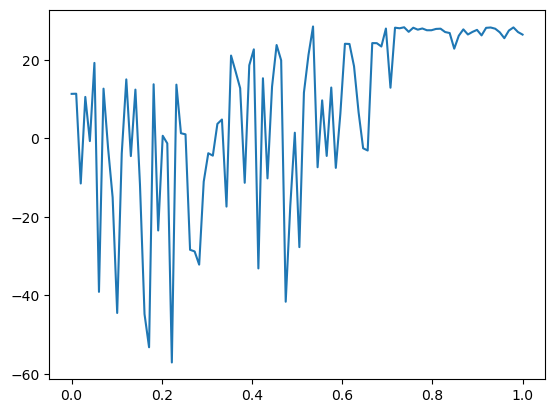

In [17]:
ret = np.zeros((0))
gMax = np.max(yStructured2)
logChecker = np.logspace(0, 7, num = 100)

for t in logChecker:
    ret = np.append(ret, sAWR(yUnstructured0, 100000, .99, 1, t, 0.999) / gMax)

plt.plot(np.linspace(0, 1, np.size(logChecker)), ret)
plt.show()

<h2>Classic Simulated Annealing with Hill Climbing</h2>

In [18]:
def cSA(nump, temp, coolRate, minCool, climbRate, climbCool):
    #Select random point
    x = np.random.randint(nump.size)
    
    xPDF = 0
    
    while (temp >= minCool):
        #New random x
        nX = np.random.randint(nump.size)
        #Probability of change in x
        if (nump[nX] >= nump[x]):
            xPDF = 1
        else:
            #Just Euler's number with a sigmoid function as the exponent
            xPDF = np.exp((nump[nX] - nump[x]) / temp)
            
        x = np.random.choice([x, nX], p=[1 - xPDF, xPDF])     
        x = climb(x, nump, climbRate)
        
        climbRate *= climbCool
        temp *= coolRate
        
    return nump[x] 

<h2>Genetic Optimization Algorithm based on Selecting from End-Result Healthy Population</h2>
<p>There is so much you can do with this, and there are so many parameters you could add.

<h4><i>Cumulative and probability density function maker that gives numpy arrays.  Helps converge to global maximum nad lead to healthy population.</i></h4>

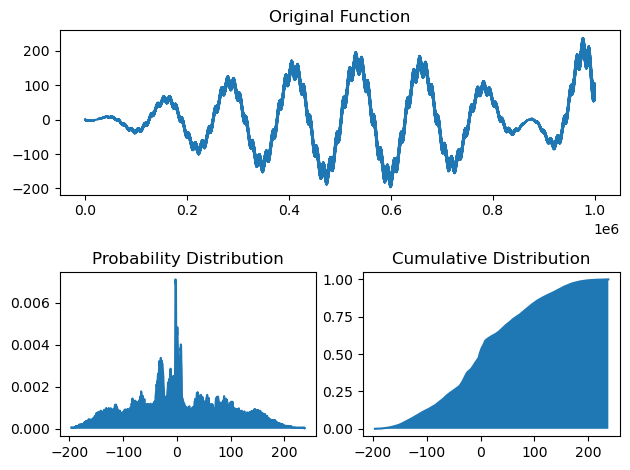

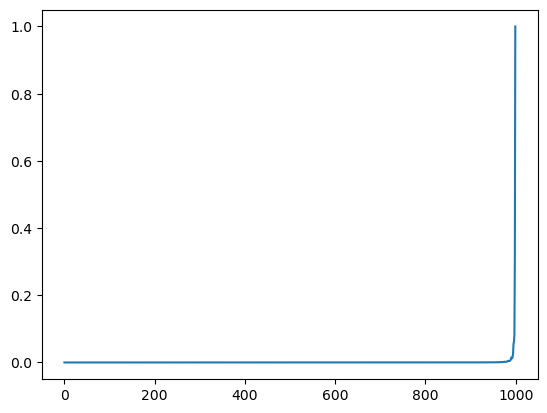

1.7087332461630198


In [134]:
#Make almost any function into a PDF of how many times a y value occurs in frequency throughout the function
def makePDF(nump, resolution, steps): 
    normalizer0 = np.max(nump) - np.min(nump)
    size = np.size(nump)
    mean = np.mean(nump)
    minimum = np.min(nump)
    bucketVolume = normalizer0 / resolution
    buckets = np.zeros((resolution + 1, 2))
    
    #Set the bucket intervals
    buckets[0, 0] = np.min(nump)
    for i in range(1, resolution + 1):
        buckets[i] = [buckets[i - 1, 0] + bucketVolume, 0]
        
    #Add to the buckets
    for i in range(0, np.size(nump), steps):
        #Bucket interval to be stored in
        index = int((nump[i] - minimum) / bucketVolume)
        buckets[index, 1] += 1
           
    #Get rid of last value, as there's no information
    buckets = np.delete(buckets, resolution, 0)
    #Normalize the y-values
    normalizer1 = np.sum(buckets, axis = 0)[1]
    for i in range(0, resolution):
        buckets[i, 1] /= normalizer1
        
        
    return buckets



def getProbPDF(x, pdf):
    for i in range(0, np.size(pdf, axis = 0) - 1):
        if (x >= pdf[i, 0] and x < pdf[i + 1, 0]):
            return pdf[i, 1]
    return 0
        
        
        



#CDF is very intuitive and simple with the PDF
def makeCDF(nump, resolution, steps):
    pdf = makePDF(nump, resolution, steps)
    
    cdf = np.zeros((resolution, 2))
    cdf[0, 0] = pdf[0, 0]
    cdf[0, 1] = pdf[0, 1]
    
    #Integrate the PDF
    for i in range(1, resolution):
        if (cdf[i - 1, 1] == 1):
            cdf[i, 0] = pdf[i, 0]
            cdf[i, 1] = 1
        else:
            cdf[i, 0] = pdf[i, 0]
            cdf[i, 1] += cdf[i - 1, 1] + pdf[i, 1]

            
    return cdf


def getProbCDF(x, cdf):
    for i in range(0, np.size(cdf, axis = 0) - 1):
        if (x >= cdf[i, 0] and x < cdf[i + 1, 0]):
            return cdf[i, 1]
    return 0




#This returns a random point based on probability given any function: it the x-value if you randomly pick any point in the integral/area under the PDF.  That's really all you need to know unless you want to read the long reasoning below to prove it and get a mind full.  I was on a roll.
#It will always sum to 1 once it reaches the end
#Normalize the x-axis of the CDF and use a random, uniform distribution of probability times the CDF to get the random number.  Un-normalize the x-axis and return the number.
#For every member of the CDF array, multiply a member of the uniform probability CDF the size of the of the given CDF
#A mega-infinite set (Aleph-one?) of what's defined as "random numbers" has a perfect, constant slope at all its infinite points (Aleph-null?) in its CDF.
#If any single point in a mega-infinite set of definitionally random numbers were to change, its CDF's (and PDF's) slope would no longer be constant, and it would no longer be random relative to you, because you would have knowledge of where you need to place the said single point.
#This is true if you move any and all the points in the mega-infinite set and try to get it back to the original CDF or PDF.  You have now brought down the function to your knowledge plane/Aleph level.  It can no longer be random relative to you.

#To put it another way, we need a CDF that gives as little information as possible and has the same number of members as the function we're multiplying it by.  This is just a CDF with a constant slope.
#Look at the "Random" graphs below for the intuitive example.
def pointsBasedOnProbability(nump, resolution, steps):
    pdf = makePDF(nump, resolution, steps)
    
    #Multiply it by a "prefect" CDF from a uniform, random distribution at the same size and use it to choose
    #Uniform distribution starts at the first step size and ends at 1 to guarantee a return
    size = np.size(pdf, axis = 0)
    retNump = np.zeros((size, 2))
    currNormalizer = size
    randPoint = 0
    probSum = 1 
    for i in range(0, size):
        probability = pdf[i, 1]  / (probSum * currNormalizer)
        #if(randPoint == 0):
            #randPoint = np.random.choice([0, pdf[i, 0]], 1, p = [1 - probability, probability])
        retNump[i] = [i, probability]
        probSum -= pdf[i, 1]
        currNormalizer -= 1
        
    return retNump 








array = yStructured0
resRate = 0.001
steps = 1
func = makePDF(array, int(np.size(array) * resRate), steps)
xP = func[:, 0]
yP = func[:, 1]
func = makeCDF(array, int(np.size(array) * resRate), steps)
xC = func[:, 0]
yC = func[:, 1] 

#Plot them out
plot1 = plt.subplot2grid((4, 4), (0, 0), rowspan = 2, colspan = 4) 
plot2 = plt.subplot2grid((4, 4), (2, 0), rowspan = 2, colspan = 2) 
plot3 = plt.subplot2grid((4, 4), (2, 2), rowspan = 2, colspan = 2) 

plot1.plot(array)
plot1.set_title('Original Function') 

plot2.plot(xP, yP)
plot2.fill_between(xP, yP)
plot2.set_title('Probability Distribution') 

plot3.plot(xC, yC)
plot3.fill_between(xC, yC)
plot3.set_title('Cumulative Distribution')

plt.tight_layout() 
plt.show()


func = pointsBasedOnProbability(array, int(np.size(array) * resRate), steps)
xW = func[:, 0]
yW = func[:, 1]
plt.plot(xW, yW)
plt.show()
print(np.sum(yW))

<h4><i>The actual genetic algorithm.</i></h4>
<p>This is the main function.</p>

In [29]:
#This is to return an integer for how many a member will mate.  It is random, and will always average out to whatever entered without ever returning a negative.
#Some interesting math here since it cannot go below 0 and must return an integer while maintaining an average (mateRate).
def timesToMate(mateRate):
    s = np.random.poisson(mateRate, 10000)
    return np.round(np.random.choice(s, 1))



#Main genetic algorithm
#A little different than most.  This algorithm is more about getting a healthy, reasonably-sized population that converges into similar fitness levels and choosing only the best 
#at the end once the fitness level's standard deviation among the population has shrunk to a sufficiently low level indicating a max.  
def gA(nump, popSize, minPop, mutRate, selRate, mateRate, finalGenDeviation, maxGenerations, lifespan, cullRate, monogamous, pairingChances, pairingRate, lifelongPairing):
    #Create the initial population and store fitness in associated array
    x = np.random.randint(0, nump.size)
    #Dummy value
    population = np.array([[0, 0, 0, 0, 0, 0, 0]])
    iD = 0
    #ID of member
    for _ in range(0, popSize):
        x = np.random.randint(0, nump.size)
        #population[0] is its x-value
        #population[1] is its y-value
        #population[2] is its lifespan left
        #population[3] is whether they've mated this generation or not
        #population[4] is 0 if never paired, 1 if paired with alive mate, and 2 if dead mate
        #population[5] is a unique ID for each member
        #population[6] is their mate's ID and False otherwise
        iD += 1
        population = np.vstack([population, [x, nump[x], lifespan, False, 0, iD, False]])
    
    newPop = np.empty((1, 7))

    
    #Used to compare the initial deviation to the final
    finalGenDeviation = (np.std(population, axis = 0))[1] * finalGenDeviation 
    #Initial environmental selection rate should be fixed to avoid purity spiraling, as that's more what culling is for 
    envMean = (np.mean(population, axis = 0))[1]
    envSD = (np.std(population, axis = 0))[1]  
    
    
    
    #Main loop of generations
    while ((np.std(population, axis = 0))[1]  > finalGenDeviation and maxGenerations > 0 and (np.size(population, axis = 0)) > minPop):
        
        currSD = (np.std(population, axis = 0))[1]
        currMean = (np.mean(population, axis = 0))[1]
        currPopSize = (np.size(population, axis = 0))
        
        #Environmental selection process                               
        #Selection criteria is based on Guassian Normal Distribution where selRate is what cuts off everything on the left side (0.0 - 1.0) 
        for t in range(1, np.size(population, axis=0)):
            if (stats.norm.cdf(population[t][1], envMean, envSD) > selRate and lifespan > 0):
                newPop = np.vstack([newPop, population[t]])
            elif (monogamous):
                #Since it died, change the mating status of its partner
                for j in range(1, np.size(population, axis=0)):
                    if (population[t][6] == population[j][5]):
                        population[j][4] = 2
                        population[j][6] = False
        
        population = np.delete(newPop, 0, 0)
        newPop = np.empty((1, 7))
        
        
        
        currSD = (np.std(population, axis = 0))[1]
        currMean = (np.mean(population, axis = 0))[1]
        currPopSize = (np.size(population, axis = 0))
        
        #Culling selection process
        #Same as above, but selection is dependent on current SD and mean of the population
        #Idea is that members of group select against themselves
        #Different from sexual selection in that worse members are actively removed
        for t in range(0, np.size(population, axis=0)):
            if (stats.norm.cdf(population[t][1], currMean, currSD) > cullRate):
                newPop = np.vstack([newPop, population[t]])
            elif (monogamous):
                #Since it died, change the mating status of its partner
                for j in range(0, np.size(population, axis=0)):
                    if (population[t][6] == population[j][5]):
                        population[j][4] = 2
                        population[j][6] = False
        
        population = np.delete(newPop, 0, 0)
        newPop = np.empty((1, 7))
            
        
        
        currSD = (np.std(population, axis = 0))[1]
        currMean = (np.mean(population, axis = 0))[1]
        currPopSize = (np.size(population, axis = 0))
        
        #Crossover/mating process with added mutations
        #Crossover/mating process is essentially that more "attractive" (higher fitness) mates mate more based on the mateRate.
        #Mating is going to be relative to the current population's fitness and size, because population would explode if it were based on fitness to environment.
        #This could be made way more sophisticated/possibly faster and is something to focus on.
        children = np.empty((1, 7))
        
        #Monogomous are also more likely to mate with others of similar fitness
        #The first for-loop is how many chances people get to find a partner based on chances variable, because some members are always going to be left out unless iterated.
        #In the end, some are just not going to be able to mate unless you set chances to high.
        #You could make it so that higher fitness members get first pickings, but it may cancel out probabilities.  Unsure.  More research needed.
        #Looks bad with a triple for-loop, but it has a lot of time saving if-statements
        if (monogamous):
            #Resetting mating status
            for t in range(0, np.size(population, axis=0)):
                population[t][3] = False
                
            #Section for pairing
            for _ in range(0, pairingChances):
                for t in range(0, np.size(population, axis=0)):
                    #If they don't have a mate yet/anymore, give them a mate depending on lifelong
                    if ((population[t][4] == 2 and lifelongPairing == False) or (population[t][4] == 0)):
                        for j in range(t + 1, np.size(population, axis=0)):
                            #Continue if j has a mate already
                            if ((population[j][4] == 2 and lifelongPairing == True) or population[j][4] == 1):
                                continue
                            #Get all the probabilities to mate to sum to 1
                            #Normal CDF may not be the best for this, but it's better than uniform.  Can experiment with it.
                            #pairingRate is how picky mating is where 0 < pairingRate 
                            probTBonds = stats.norm.cdf(population[t][1], currMean, currSD * (1 / pairingRate))
                            probJBonds = stats.norm.cdf(population[j][1], currMean, currSD * (1 / pairingRate))
                            #Very simple and could be added upon
                            probToBond = (probTBonds + probJBonds) / 2
                            bondBool = np.random.choice([0, 1], p = [1 - probToBond, probToBond])
                            if (bondBool):
                                population[t][4] = 1
                                population[t][6] = population[j][5]
                                population[j][4] = 1
                                population[j][6] = population[t][5]
            #Mating section for monogomous
            for t in range(0, np.size(population, axis=0)):
                for j in range(t + 1, np.size(population, axis=0)):
                    if (population[t][6] == population[j][5]):
                        for _ in range(0, timesToMate(mateRate)[0]):
                            childX = (round((population[t][0] + population[j][0]) / 2 + mutRate * np.size(nump))) % np.size(nump)
                            childY = nump[childX]
                            iD += 1
                            children = np.vstack([children, [[childX, childY, lifespan, False, 0, iD, False]]])
        
                    
        #Non-monogomous mate almost indiscernibly, but more fit members are still more likely to mate
        else:
            for t in range(0, np.size(population, axis=0)):
                probToMate = (mateRate * stats.norm.cdf(population[t][1], currMean, currSD) / currPopSize)
                for j in range(t + 1, np.size(population, axis=0)):
                    #Error check
                    if (probToMate != probToMate):
                        probToMate = 0
                    #How many times they mate is dependent on the mateRate and 
                        mateBool = np.random.choice([0, 1], p = [1 - probToMate, probToMate])
                        if (mateBool):
                            childX = (round((population[t][0] + population[j][0]) / 2 + mutRate * np.size(nump))) % np.size(nump)
                            childY = nump[childX]
                            iD += 1
                            children = np.vstack([children, [[childX, childY, lifespan, False, 0, iD, False]]])

        children = np.delete(children, 0, 0)
        population = np.concatenate((population, children), axis = 0)
        
        
        currSD = (np.std(population, axis = 0))[1]
        currMean = (np.mean(population, axis = 0))[1]
        currPopSize = (np.size(population, axis = 0))
        
        maxGenerations -= 1
        
        
    #Find fittest member
    if (np.size(population, axis = 0) == 1):
        maxxed = [0, 0]
    else:
        maxxed = population[0]
        for t in range(1, np.size(population, axis = 0)):
            if (population[t][1] > maxxed[1]): 
                maxxed = population[t]
                
    
    
    #Return the fittest member's x value, its fitness, end-population size, end-population standard deviation, and the end-population members' x and y values
    return [maxxed[0], maxxed[1], currPopSize, currMean, currSD / envSD], population


<h4><i>Some presets that offer high performance in different, interesting ways.</i></h4>
<p>It is most interesting to see that genetic diversity always shrinks no matter what the mutation rate is.</p>

In [58]:
#def gA(nump, popSize, minPop, mutRate, selRate, mateRate, finalGenDeviation, maxGenerations, lifespan, cullRate, monogamous, pairingChances, pairingRate, lifelongPairing):

#Choose a data set here.
dataSet = yStructured0

gMax = np.max(dataSet)

#For yStructured3
#gMax = 25.066282746310005


#Viltrumite: 
startTime = time.time()
viltrumite, vilPop = gA(dataSet, 1000, 100, 0.05, 0.4, 20, .05, 100, 1000, 0.8, True, 4, 2, False)
endTime = time.time() - startTime
viltrumite = np.append(viltrumite, endTime)
viltrumite[1] /= gMax
viltrumite[3] /= gMax


#Kryptonian: 
startTime = time.time()
kryptonian, kryptPop = gA(dataSet, 1000, 10, 0.0, 0.75, 4, .05, 10, 1, 0.02, True, 8, 1, True)
endTime = time.time() - startTime
kryptonian = np.append(kryptonian, endTime)
kryptonian[1] /= gMax
kryptonian[3] /= gMax


#Manhattanite: 
startTime = time.time()
manhattanite, manPop = gA(dataSet, 100, 5, 0, 0.6, 20, 0.001, 10, 1000, 0.66, False, 6, 2, False)
endTime = time.time() - startTime
manhattanite = np.append(manhattanite, endTime)
manhattanite[1] = getProbCDF(manhattanite[1], makeCDF(dataSet, 100000, 1))
manhattanite[3] = getProbCDF(manhattanite[3], makeCDF(dataSet, 100000, 1))


#CUSTOM
startTime = time.time()
custom, custPop = gA(dataSet, 100, 10, 0.0, 0.1, 4, .05, 10, 10, 0.2, True, 8, 1, True)
endTime = time.time() - startTime
custom = np.append(custom, endTime)
custom[1] = getProbCDF(custom[1], makeCDF(dataSet, 100000, 1))
custom[3] = getProbCDF(custom[3], makeCDF(dataSet, 100000, 1))


startTime = time.time()
np.max(dataSet)
maxs = dataSet[0]
for i in range(0, np.size(dataSet)):
    if (maxs < dataSet[i]):
        maxs = dataSet[i]
endTime = time.time() - startTime
print(endTime)


df = pd.DataFrame([viltrumite, kryptonian, manhattanite, custom], columns = ['Position', 'Best Member Fitness', 'Ending Population Size', 'Ending Population Fitness', 'Ending Population Diversity',  'Computation Time'], index = ['Viltrumite', 'Kryptonian', 'Manhattanite', 'Custom'])
df.style



0.20804691314697266


,Position,Best Member Fitness,Ending Population Size,Ending Population Fitness,Ending Population Diversity,Computation Time
Viltrumite,977610.000000,0.973242,52.000000,0.741828,0.195331,0.642143
Kryptonian,977308.000000,0.978308,600.000000,0.514365,1.000862,1.730389
Manhattanite,658391.000000,0.974424,3.000000,0.962881,0.126177,0.015003
Custom,408081.000000,0.954114,3342.000000,0.732479,0.049534,25.491748


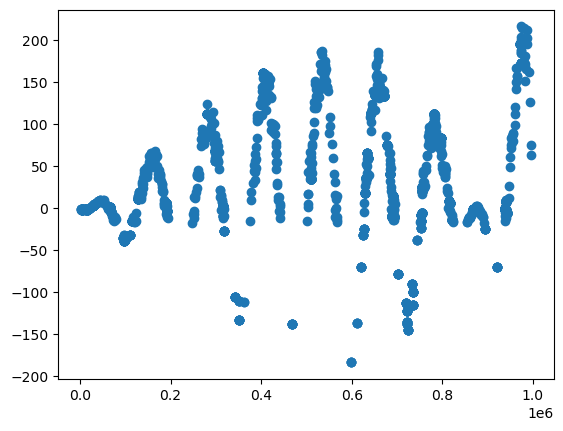

In [98]:
#CUSTOM
#def gA(nump, popSize, minPop, mutRate, selRate, mateRate, finalGenDeviation, maxGenerations, lifespan, cullRate, monogamous, pairingChances, pairingRate, lifelongPairing):
startTime = time.time()
custom, custPop = gA(dataSet, 1000, 10, 0.25, 0.40, 6, .05, 10, 1, 0.10, True, 8, 1, False)
endTime = time.time() - startTime
custom = np.append(custom, endTime)
custom[1] = getProbCDF(custom[1], makeCDF(dataSet, 100000, 1))
custom[3] = getProbCDF(custom[3], makeCDF(dataSet, 100000, 1))

plt.scatter(custPop[:, 0], custPop[:, 1])